In [8]:
import networkx as nx
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

In [11]:
# Import data
alliances = pd.read_csv("data/pre_wwi_alliances.csv")
alliances["start_date"] = pd.to_datetime(
    alliances[["dyad_st_year", "dyad_st_month", "dyad_st_day"]]
    .astype(str)
    .agg("-".join, axis=1)
)

end_date = []
for _, row in alliances.iterrows():
    try:
        end_date.append(
            datetime(
                row["dyad_end_year"].astype(int),
                row["dyad_end_month"].astype(int),
                row["dyad_end_day"].astype(int),
            )
        )
    except:
        end_date.append(None)
alliances["end_date"] = end_date

# Define the time interval
beginning = datetime(1878, 1, 1)
end = datetime(1914, 12, 31)


# Create a time filter function
def within_timeframe(row, start, end):
    if pd.isnull(row["end_date"]):
        return start <= row["start_date"] <= end
    else:
        return start <= row["start_date"] <= end and start <= row["end_date"] <= end


# Filter the data for the specific time interval and European countries
european_countries = [
    "Austria-Hungary",
    "Bulgaria",
    "France",
    "Germany",
    "Greece",
    "Italy",
    "Russia",
    "Spain",
    "Turkey",
    "United Kingdom",
    "Yugoslavia",
]
filtered_alliances = alliances[
    (alliances.apply(within_timeframe, args=(beginning, end), axis=1))
    & (alliances["state_name1"].isin(european_countries))
    & (alliances["state_name2"].isin(european_countries))
]
filtered_alliances

,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,version,start_date,end_date
450,63,200,United Kingdom,640,Turkey,4,6,1878,25.0,11.0,1880.0,0,0,1,0,0.0,0.0,4.1,1878-06-04,None
451,63,640,Turkey,200,United Kingdom,4,6,1878,25.0,11.0,1880.0,0,0,0,0,0.0,0.0,4.1,1878-06-04,None
452,64,255,Germany,300,Austria-Hungary,7,10,1879,3.0,11.0,1918.0,0,0,1,1,0.0,0.0,4.1,1879-10-07,None
453,64,300,Austria-Hungary,255,Germany,7,10,1879,3.0,11.0,1918.0,0,0,1,1,0.0,0.0,4.1,1879-10-07,None
454,65,300,Austria-Hungary,345,Yugoslavia,16,6,1881,1.0,1.0,1895.0,0,0,0,0,0.0,1.0,4.1,1881-06-16,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,94,640,Turkey,355,Bulgaria,19,8,1914,30.0,9.0,1918.0,0,0,1,0,0.0,1.0,4.1,1914-08-19,None
572,95,300,Austria-Hungary,355,Bulgaria,19,8,1914,30.0,9.0,1918.0,0,0,1,0,0.0,0.0,4.1,1914-08-19,None
573,95,355,Bulgaria,300,Austria-Hungary,19,8,1914,30.0,9.0,1918.0,0,0,1,0,0.0,0.0,4.1,1914-08-19,None
574,96,255,Germany,355,Bulgaria,6,9,1914,6.0,9.0,1918.0,0,0,1,0,0.0,0.0,4.1,1914-09-06,None


In [12]:
filtered_alliances.columns

Index(['version4id', 'ccode1', 'state_name1', 'ccode2', 'state_name2',
       'dyad_st_day', 'dyad_st_month', 'dyad_st_year', 'dyad_end_day',
       'dyad_end_month', 'dyad_end_year', 'left_censor', 'right_censor',
       'defense', 'neutrality', 'nonaggression', 'entente', 'version',
       'start_date', 'end_date'],
      dtype='object')

The dataset contains information about various types of alliances and treaties between different countries. The relevant columns for the analysis include:
* state_name1: Name of the first country involved in the alliance
* state_name2: Name of the second country involved in the alliance
* defense: Indicates whether the alliance is a defense pact
* neutrality: Indicates whether the alliance is a neutrality pact
* nonaggression: Indicates whether the alliance is a non-aggression pact
* entente: Indicates whether the alliance is an entente. Entente refers to a friendly understanding or informal alliance between states.

In [13]:
# Create edges and vertices dataframes
edges = filtered_alliances[
    [
        "state_name1",
        "state_name2",
        "defense",
        "neutrality",
        "nonaggression",
        "entente",
    ]
].rename(columns={"state_name1": "from", "state_name2": "to"})
edges["width"] = edges.groupby(["from", "to"])["from"].transform("count")
edges = edges.drop_duplicates()

vertices = pd.concat([edges["from"], edges["to"]]).unique()

# Assign sides to countries
sides = {
    "Austria-Hungary": "Central Powers",
    "Bulgaria": "Central Powers",
    "France": "Allies",
    "Germany": "Central Powers",
    "Greece": "Neutral",
    "Italy": "Central Powers",
    "Russia": "Allies",
    "Spain": "Neutral",
    "Turkey": "Central Powers",
    "United Kingdom": "Allies",
    "Yugoslavia": "Allies",
}

vertices_df = pd.DataFrame({"country": vertices})
vertices_df["side"] = vertices_df["country"].map(sides)
vertices_df["size"] = vertices_df["country"].map(
    edges["from"].value_counts().add(edges["to"].value_counts(), fill_value=0)
)

In [14]:
# Create the graph
G = nx.DiGraph()

# Add nodes
for _, row in vertices_df.iterrows():
    G.add_node(row["country"], size=row["size"], side=row["side"])

# Add edges
for _, row in edges.iterrows():
    G.add_edge(
        row["from"],
        row["to"],
        width=row["width"],
        # 'defense', 'neutrality', 'nonaggression', 'entente',
        defense=row["defense"],
        neutrality=row["neutrality"],
        nonaggression=row["nonaggression"],
        entente=row["entente"],
    )

# Define colors
color_map = {
    "Allies": "cornflowerblue",
    "Central Powers": "olivedrab",
    "Neutral": "gainsboro",
}

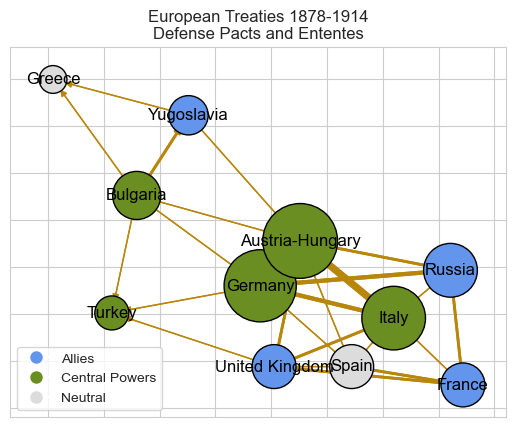

In [15]:
pos = nx.spring_layout(G)

sizes = [nx.get_node_attributes(G, "size")[node] * 100 for node in G.nodes()]
colors = [color_map[nx.get_node_attributes(G, "side")[node]] for node in G.nodes()]
widths = [G[u][v]["width"] for u, v in G.edges()]

nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, edgecolors="black")
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, width=widths, edge_color="darkgoldenrod")

plt.title("European Treaties 1878-1914\nDefense Pacts and Ententes")
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color,
        markersize=10,
        label=label,
    )
    for label, color in color_map.items()
]
plt.legend(handles=legend_elements, loc="lower left")

plt.show()

In the context of the provided network analysis:

1. **Edge Width**: The width of an edge in the network represents the number of alliances or treaties between two countries. A thicker edge indicates that there were multiple treaties or agreements between the two countries, signifying a stronger or more significant relationship. Essentially, it shows the frequency of interactions in terms of formal agreements between the nations.

2. **Node Size**: The size of a node represents the number of connections (both incoming and outgoing) a country has in the network. This can be interpreted as the degree of centrality of the country within the network, indicating its importance or influence. A larger node size means that the country has more alliances or treaties with other countries, thus playing a more pivotal role in the network of alliances. 

In this analysis, these visual attributes help to quickly identify which countries were most central to the alliance system and the strength of the relationships between various pairs of countries during the specified time period (1878-1914).

In [16]:
e = list(G.edges(data=True))
e = pd.DataFrame(e, columns=['from', 'to', 'data'])
# exppand the data column into separate columns
e = pd.concat([e.drop(['data'], axis=1), e['data'].apply(pd.Series)], axis=1)
e[['defense', 'entente']].any(axis=1)

0      True
1      True
2      True
3      True
4      True
5     False
6     False
7      True
8     False
9      True
10    False
11    False
12     True
13     True
14    False
15     True
16    False
17    False
18     True
19    False
20     True
21     True
22     True
23     True
24     True
25    False
26     True
27     True
28    False
29    False
30     True
31    False
32    False
33     True
34    False
35    False
36    False
37     True
38     True
39     True
40    False
41     True
42     True
43     True
44     True
45     True
46     True
47     True
48     True
49     True
dtype: bool

In [17]:
import numpy as np
countries = list(G.nodes())

def simulate_attack(G, attacker, target):
    involved_countries = set()
    stack = [attacker, target]

    while stack:
        current = stack.pop()
        if current not in involved_countries:
            involved_countries.add(current)
            for neighbor in G.neighbors(current):
                edge_data = G.get_edge_data(current, neighbor)
                #print(f"{current} -> {neighbor}: {edge_data}")
                if edge_data['defense']: # or edge_data['entente']):
                    stack.append(neighbor)

    return involved_countries


# Simulate the attack
attacker = "Austria-Hungary"
target = "Yugoslavia"
involved_countries = simulate_attack(G, attacker, target)
print(f'{attacker:18s} -> {target:18s}: {len(involved_countries)} / {len(countries)} ({len(involved_countries) / len(countries) * 100:.2f}%)')

Austria-Hungary    -> Yugoslavia        : 8 / 11 (72.73%)


In [18]:
m = np.zeros((len(countries), len(countries)))
for ci in countries:
    for cj in countries:
        if ci == cj:
            continue
        involved_countries = simulate_attack(G, ci, cj)
        m[countries.index(ci), countries.index(cj)] = len(involved_countries)
        print(f'{ci:18s} -> {cj:18s}: {len(involved_countries)} / {len(countries)} ({len(involved_countries) / len(countries) * 100:.2f}%)')
m = m / len(countries) * 100.0

United Kingdom     -> Turkey            : 9 / 11 (81.82%)
United Kingdom     -> Germany           : 9 / 11 (81.82%)
United Kingdom     -> Austria-Hungary   : 9 / 11 (81.82%)
United Kingdom     -> Yugoslavia        : 9 / 11 (81.82%)
United Kingdom     -> Russia            : 9 / 11 (81.82%)
United Kingdom     -> Italy             : 10 / 11 (90.91%)
United Kingdom     -> Spain             : 10 / 11 (90.91%)
United Kingdom     -> France            : 9 / 11 (81.82%)
United Kingdom     -> Bulgaria          : 9 / 11 (81.82%)
United Kingdom     -> Greece            : 9 / 11 (81.82%)
Turkey             -> United Kingdom    : 9 / 11 (81.82%)
Turkey             -> Germany           : 8 / 11 (72.73%)
Turkey             -> Austria-Hungary   : 8 / 11 (72.73%)
Turkey             -> Yugoslavia        : 8 / 11 (72.73%)
Turkey             -> Russia            : 8 / 11 (72.73%)
Turkey             -> Italy             : 9 / 11 (81.82%)
Turkey             -> Spain             : 9 / 11 (81.82%)
Turkey      

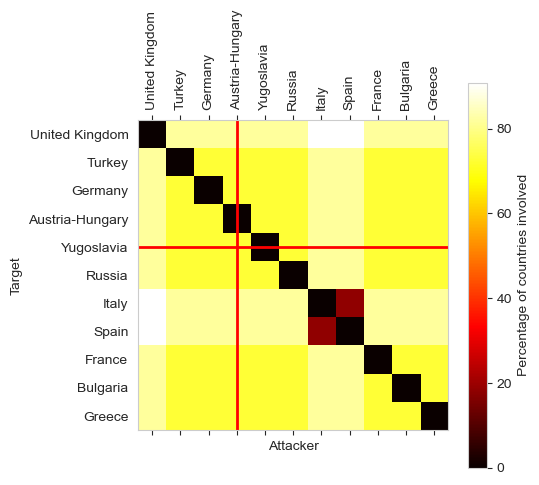

In [19]:
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(m, cmap="hot")
ax.set_xticks(np.arange(len(countries)))
ax.set_yticks(np.arange(len(countries)))
ax.set_xticklabels(countries, rotation=90)
ax.set_yticklabels(countries)
ax.grid(False)
ax.set_xlabel("Attacker")
ax.set_ylabel("Target")
ax.axvline(countries.index(attacker), color="red", linewidth=2)
ax.axhline(countries.index(target), color="red", linewidth=2)
plt.colorbar(cax, label="Percentage of countries involved")